In [1]:
from datetime import datetime
import numpy as np
import xgboost as xgb

%load_ext memory_profiler

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from pipeline_v1.mb import MoodBoost
from pipeline_v1.optimizing import SubjectwiseCrossVal, MoodBoostOptimizer
from pipeline_v1.signal_pross import get_hr
from pipeline_v1.truth import IeeeGroundTruth

## 1. Process and align RGB data from video with ground truth BVP data

In [4]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'pipeline_v1/channel_data3')  # we only use the first trial for each subject
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb(
        minmax = False,
        use_wavelet = True,
        use_bandpass = False
    )
    truth.process_bvp()
    truths.append(truth)

## 2. Train the model and validate using subject 7

In [5]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = MoodBoost(
    truths, random_state = None, loss_type = 'combined',
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642, 
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, finetune = True
)
mod.fit()



On batch 1 of 5:
[0]	train-rmse:0.83702	train-hr_err:0.23949	test-rmse:0.85471	test-hr_err:20.44495
[5]	train-rmse:0.84143	train-hr_err:0.23949	test-rmse:0.85600	test-hr_err:19.23019
[10]	train-rmse:0.84584	train-hr_err:0.23949	test-rmse:0.85732	test-hr_err:17.99148
[15]	train-rmse:0.85023	train-hr_err:0.23949	test-rmse:0.85866	test-hr_err:17.97073
[20]	train-rmse:0.85456	train-hr_err:0.16288	test-rmse:0.86034	test-hr_err:19.17520
[25]	train-rmse:0.85886	train-hr_err:0.08643	test-rmse:0.86231	test-hr_err:19.93664
[30]	train-rmse:0.86316	train-hr_err:0.08643	test-rmse:0.86432	test-hr_err:20.36338
[31]	train-rmse:0.86402	train-hr_err:0.08643	test-rmse:0.86472	test-hr_err:20.36338
Fintuning...
[0]	train-rmse:1.25453	train-hr_err:0.07118	test-rmse:0.86399	test-hr_err:20.33639
[5]	train-rmse:1.24858	train-hr_err:0.07118	test-rmse:0.86042	test-hr_err:22.00278
[7]	train-rmse:1.24620	train-hr_err:0.14729	test-rmse:0.85900	test-hr_err:24.25431


On batch 2 of 5:
[0]	train-rmse:0.53626	train-h

## 2.5. Save the model

In [7]:
mod.save('moodboost.xgb')

## Print the model stats



MSE: 0.09664608907940649
HR error: 19.46290471058432
HR error squared: 396.53422823079495


Best test loss: 17.761568


Feature importances:


,feature,importance
0,f3,41.579636
1,f20,36.043667
2,f19,30.203272
3,f33,30.175447
4,f1,29.421236
5,f30,28.863894
6,f16,26.366999
7,f21,25.885792
8,f26,23.865734
9,f28,20.623602


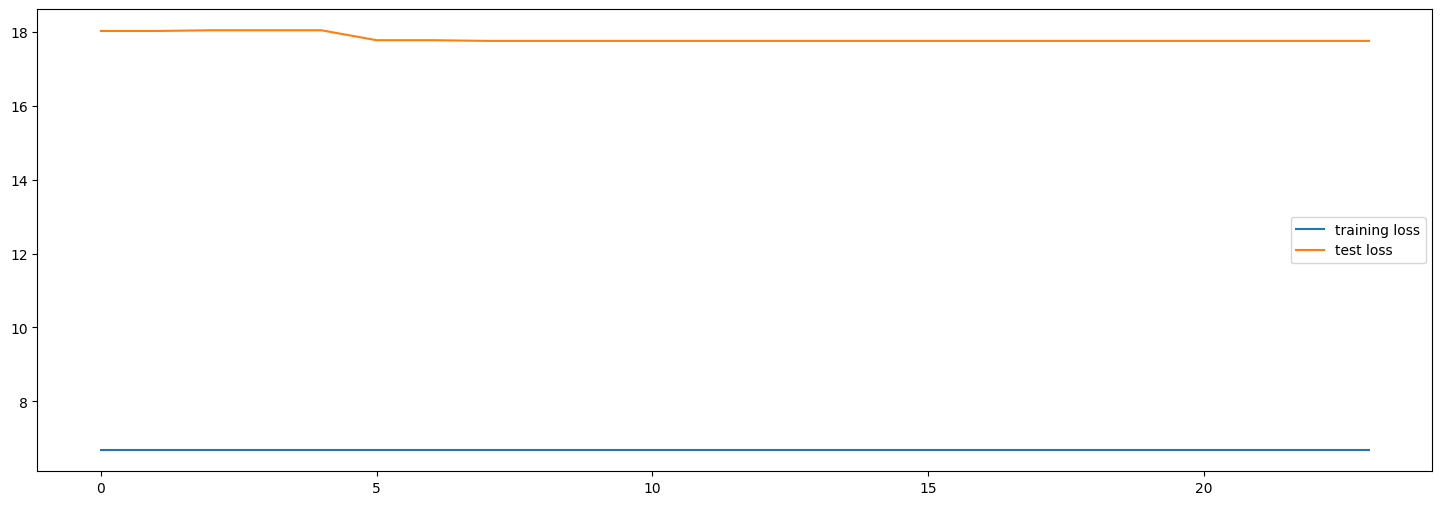

In [6]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_hr_loss()

## Plot the predicted signal versus its ground truth

peak memory: 243.21 MiB, increment: 0.20 MiB
Time elapsed: 0:00:00.036460
True HR: 48.607594936708864; Pred HR: 78.27859569648923


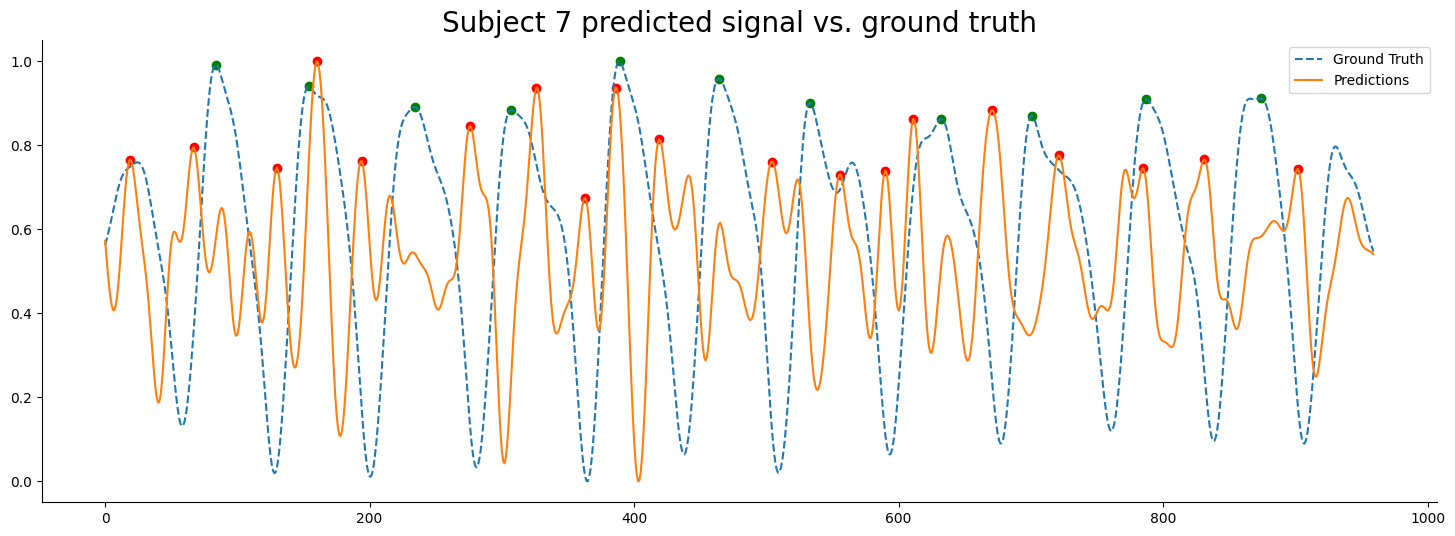

In [7]:
# beginning point from which to plot
beg = 3000
end = beg + 960  # we add 960 bc that's the period which HR error is calculated; it's also the amount of user video needed to calculate HR error (15s)

# prepare test subject data for ML, and give it the corresponding mem feats (8 mem feat, 12 skip amount)
data = test_subject_truth.prepare_data_for_ml(8, 12)

# get input data and target data
X = xgb.DMatrix(data.drop(columns = ['bvp']).to_numpy())
y = data['bvp'].to_numpy()

# get the model predictions in this method so that RAM usage is measured accurately
def measure_code_block():
    t = datetime.today()
    targ = y[beg: end]
    pred = mod.predict(X)
    pred = pred[beg: end]
    targ, pred = mod.process_signal(targ, pred, use_bandpass=True)
    elapsed_time = datetime.today() - t
    return targ, pred, elapsed_time

# measure the RAM usage of the model while also getting the predictions and processing both predictions and targets
%memit targ, pred, elapsed_time = measure_code_block()
print('Time elapsed:', elapsed_time)

# get the predicted and true peaks for each signal
pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

# create the plot
plt.plot(targ, linestyle = '--', label = 'Ground Truth')
plt.plot(pred, label = 'Predictions')
plt.legend()
plt.title(f'Subject {test_subject} predicted signal vs. ground truth', fontsize = 20)

# modify plot appearance
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')

# plot the peaks
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

# compute the predicted and true HR for this block
pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

## 4. Apply cross-validation to validate performance

In [8]:
rpm = 5
res = SubjectwiseCrossVal(
    truths, random_state = None, loss_type = 'combined', rounds_per_model = rpm,
    n_estimators = 188, split_size = 960, learning_rate = 0.001,
    early_stopping_rounds = 16, mse_weight = 0.2, dtw_weight = 0.8, data_beg = 8000, data_end = 10180,
    batches = 5, min_bandpass_freq = 0.7, max_bandpass_freq = 4.0, bandpass_order = 4,
    predicted_peaks_prominence = 0.28,
    true_peaks_prominence = 0.322741927274642,
    max_depth = 6, max_bin = 235, num_feats_per_channel = 8, skip_amount = 12, collect = True
)



On batch 1 of 5:
[0]	train-rmse:0.85150	train-hr_err:5.28482	test-rmse:0.80010	test-hr_err:28.58507
[5]	train-rmse:0.85570	train-hr_err:5.28482	test-rmse:0.80044	test-hr_err:28.58507
[10]	train-rmse:0.85993	train-hr_err:1.06005	test-rmse:0.80101	test-hr_err:26.74821
[15]	train-rmse:0.86404	train-hr_err:1.06005	test-rmse:0.80153	test-hr_err:26.77618
[20]	train-rmse:0.86805	train-hr_err:3.54980	test-rmse:0.80201	test-hr_err:28.60435
[24]	train-rmse:0.87126	train-hr_err:3.54980	test-rmse:0.80243	test-hr_err:28.57900
Fintuning...
[0]	train-rmse:1.25805	train-hr_err:3.61930	test-rmse:0.80211	test-hr_err:28.57900
[5]	train-rmse:1.25237	train-hr_err:3.55281	test-rmse:0.79999	test-hr_err:26.72016
[10]	train-rmse:1.24675	train-hr_err:1.42533	test-rmse:0.79618	test-hr_err:36.74790
[15]	train-rmse:1.24115	train-hr_err:4.63873	test-rmse:0.79184	test-hr_err:21.83821
[20]	train-rmse:1.23556	train-hr_err:11.48329	test-rmse:0.78923	test-hr_err:15.49443
[25]	train-rmse:1.23001	train-hr_err:19.59863	t

## Bayesian hyperparameter optimization demonstration

In [1]:
optimizer = MoodBoostOptimizer(truths)
result = optimizer.optimize(n_calls = 10)
print(result)